In [1]:
import time
from pathlib import Path
import numpy as np
import os, sys
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from functools import partial

import utils.training as train_utils

from utils.training import adjust_learning_rate, schedule, save_checkpoint
from utils.training import seg_cross_entropy
import augerino.models as models
from augerino.camvid_data import camvid_loaders

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model_cfg = models.FCDenseNet67

In [3]:
loaders, num_classes = camvid_loaders(
    "/home/izmailovpavel/datasets/CamVid/",
    4,
    4,
    ft_batch_size=1,
    transform_train=model_cfg.transform_train,
    transform_test=model_cfg.transform_test,
    joint_transform=model_cfg.joint_transform,
    ft_joint_transform=model_cfg.ft_joint_transform,
    target_transform=model_cfg.target_transform
)

/home/izmailovpavel/datasets/CamVid/


## Loading the model

In [5]:
model = model_cfg.base(
    *model_cfg.args,
    num_classes=num_classes,
    **model_cfg.kwargs,
    use_aleatoric=False
)
model.cuda();

ckpt = torch.load("ckpts/tiramisu_rotcamvid/run1/checkpoint-900.pt")
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [6]:
def rotate(img, z):
    num = img.shape[0]
    affineMatrices = torch.zeros(num, 2, 3)
    affineMatrices[:,0,0] = z.cos()
    affineMatrices[:,0,1] = -z.sin()
    affineMatrices[:,1,0] = z.sin()
    affineMatrices[:,1,1] = z.cos()
    
    if len(img.shape) == 3:
        img_ = img.float()[:, None] + 1
        flowgrid = F.affine_grid(affineMatrices, size=img_.size(), align_corners=True)
        img_ = F.grid_sample(img_, flowgrid, align_corners=True).int()
        img_ -= 1
        img_[img_ == -1] = 12
        return img_[:, 0]
    else:
        flowgrid = F.affine_grid(affineMatrices, size=img.size(), align_corners=True)
        return F.grid_sample(img, flowgrid, align_corners=True)

In [11]:
for x, y in loaders["test"]:
    break

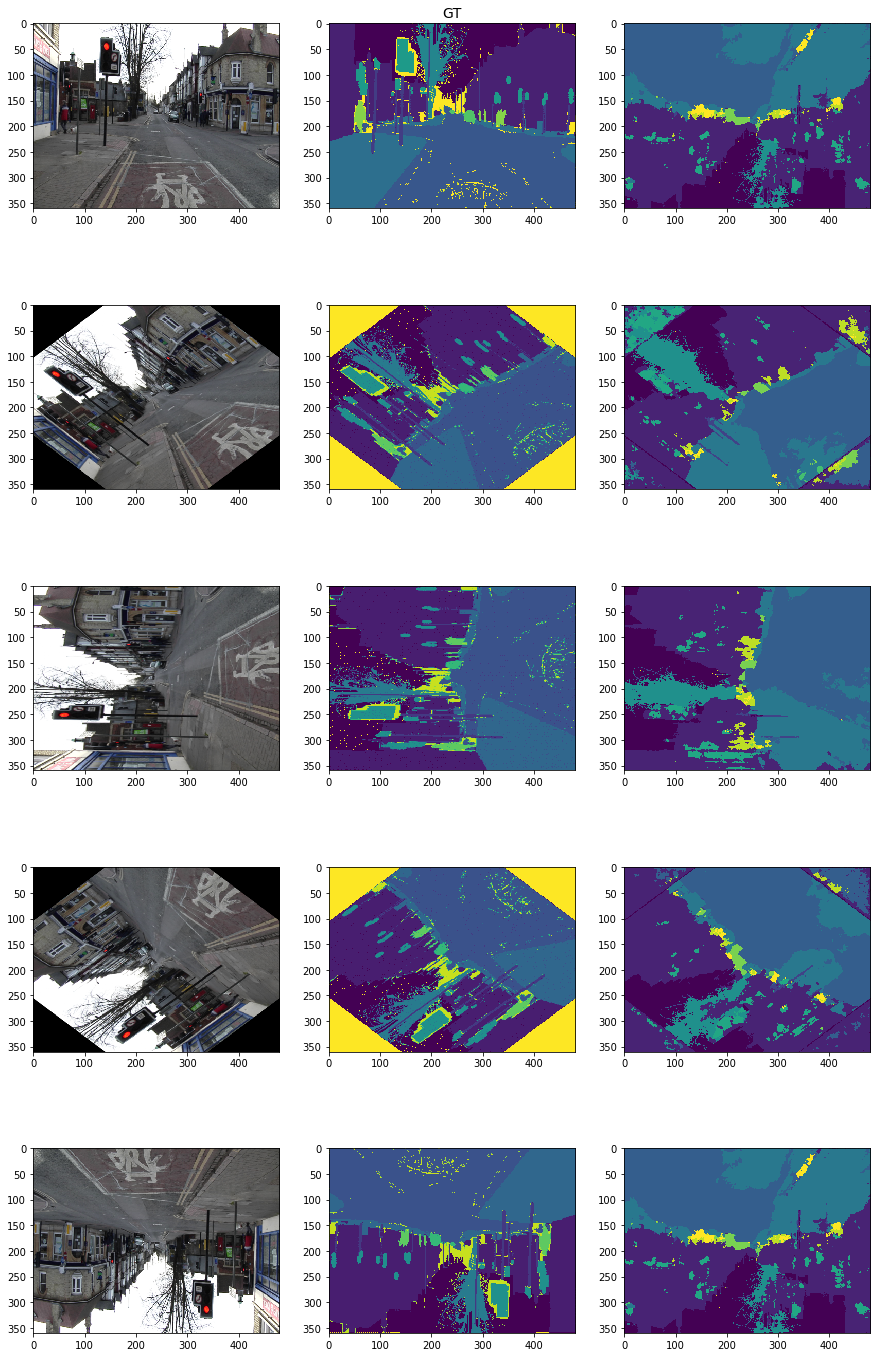

In [12]:
zs = torch.linspace(0, np.pi, 5)

nrow, ncol = len(zs), 3
f, arr = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))

for i, z in enumerate(zs):
    x_ = rotate(x, z[None].repeat((4)))
    y_ = rotate(y, z[None].repeat((4)))
    with torch.no_grad():
        pred = model(x_.cuda())
        pred = torch.max(pred, dim=1)[1]
    arr[i, 0].imshow(x_[0].permute(1,2,0).detach().cpu().numpy())
    arr[i, 1].imshow(y_[0].detach().cpu().numpy())
    arr[i, 2].imshow(pred[0].detach().cpu().numpy())
    
arr[0, 0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[0, 1].set_title("GT", fontsize=14)
arr[0, 2].imshow(pred[0].detach().cpu().numpy())
plt.show()

## stabilized view

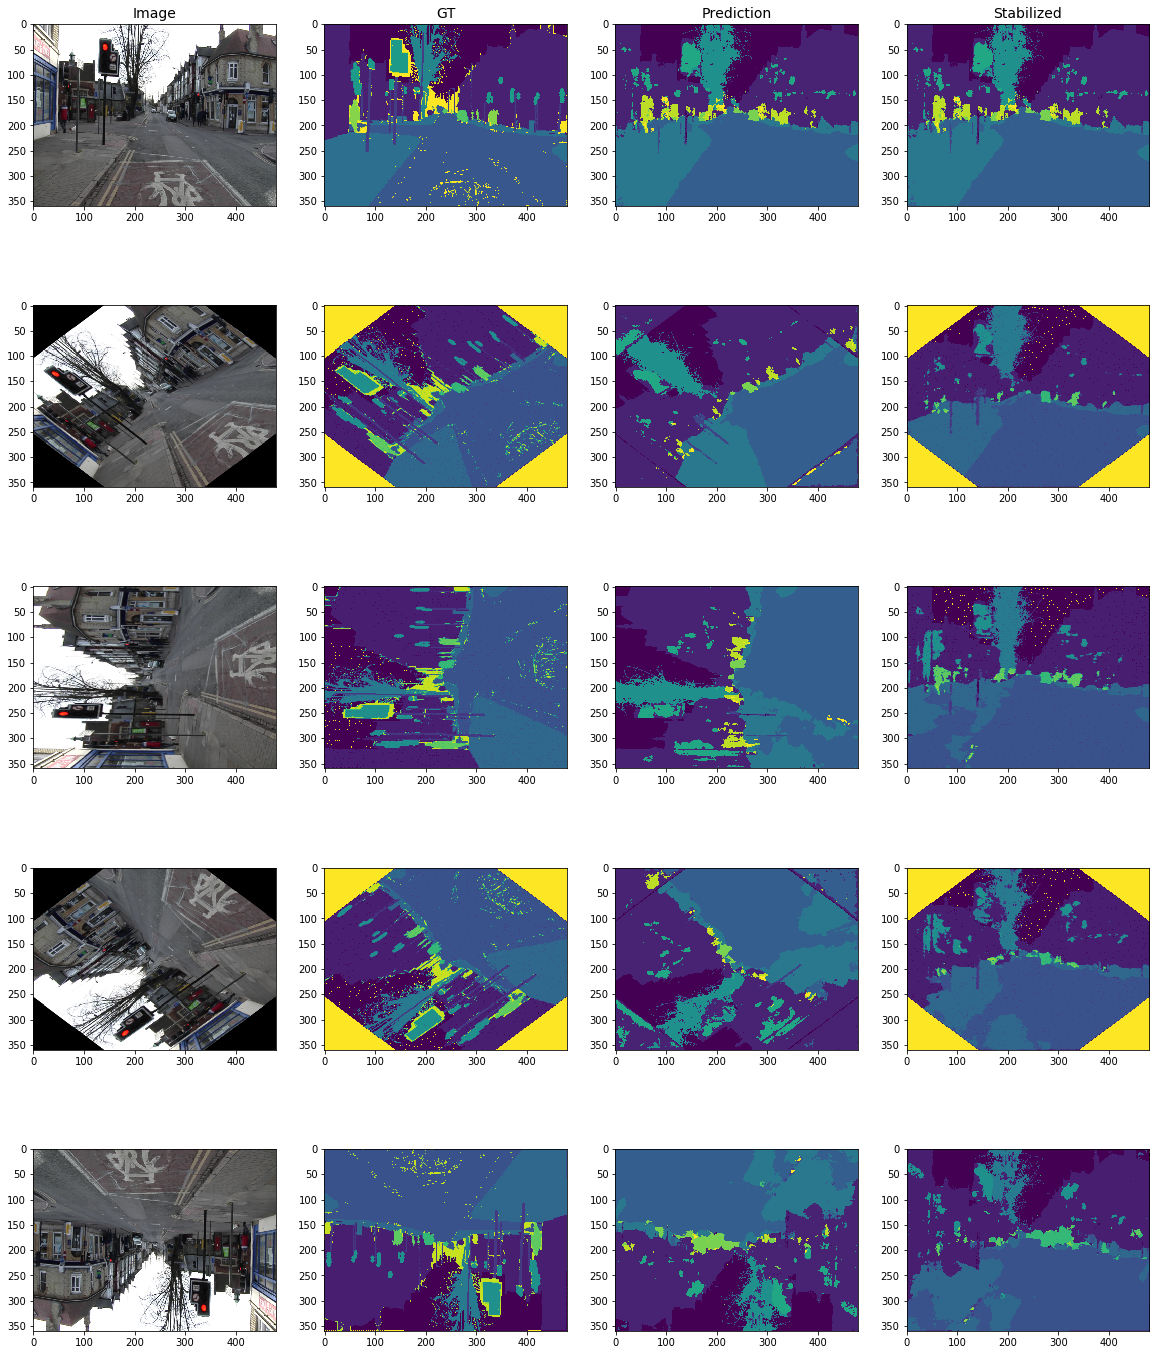

In [13]:
zs = torch.linspace(0, np.pi, 5)

nrow, ncol = len(zs), 4
f, arr = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))

for i, z in enumerate(zs):
    x_ = rotate(x, z[None].repeat((4)))
    y_ = rotate(y, z[None].repeat((4)))
    with torch.no_grad():
        pred = model(x_.cuda())
        pred = torch.max(pred, dim=1)[1]
    pred_ = rotate(pred.detach().cpu(), -z[None].repeat((4)))
    arr[i, 0].imshow(x_[0].permute(1,2,0).detach().cpu().numpy())
    arr[i, 1].imshow(y_[0].detach().cpu().numpy())
    arr[i, 2].imshow(pred[0].detach().cpu().numpy())
    arr[i, 3].imshow(pred_[0].detach().cpu().numpy())
    
arr[0, 0].set_title("Image", fontsize=14)
arr[0, 1].set_title("GT", fontsize=14)
arr[0, 2].set_title("Prediction", fontsize=14)
arr[0, 3].set_title("Stabilized", fontsize=14)
plt.show()

## Let's make a rotationally-equivariant version

In [14]:
from augerino.aug_eq_model import DiffEqAug, AugEqModel

In [15]:
aug = DiffEqAug(padding=50)

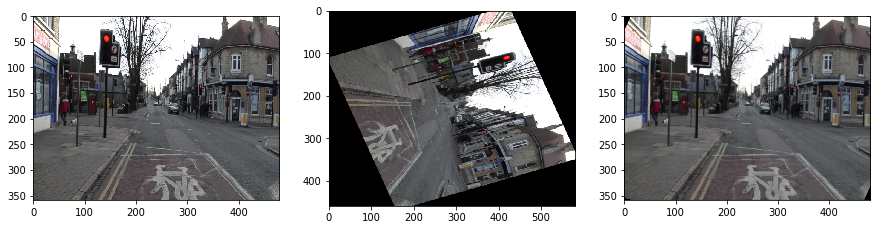

In [16]:
for x, y in loaders['test']:
    break
    
with torch.no_grad():
    x1 = aug(x)
    x2 = aug.inverse(x1)
    
f, arr =  plt.subplots(1, 3, figsize=(15, 5))
arr[0].imshow(x[0].permute(1,2,0).detach().cpu().numpy())
arr[1].imshow(x1[0].permute(1,2,0).detach().cpu().numpy())
arr[2].imshow(x2[0].permute(1,2,0).detach().cpu().numpy())

In [23]:
aug = DiffEqAug(padding=20)
augerino_model = AugEqModel(model, aug)
augerino_model.cuda();
augerino_model.eval();

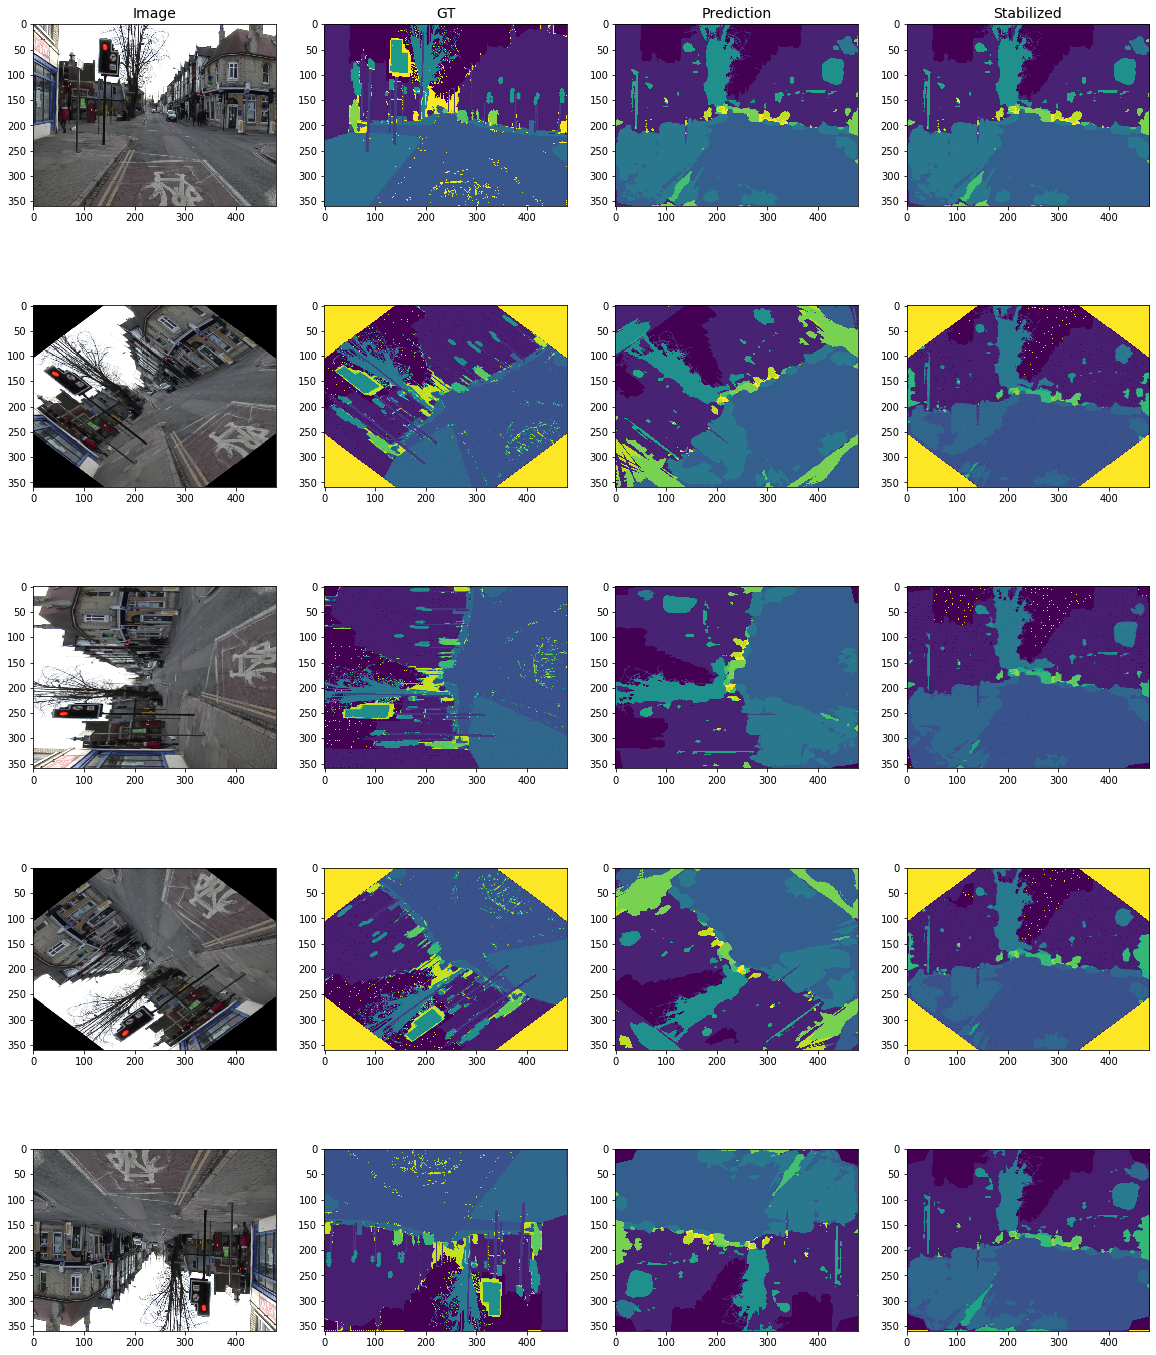

In [24]:
zs = torch.linspace(0, np.pi, 5)

nrow, ncol = len(zs), 4
f, arr = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))

for i, z in enumerate(zs):
    x_ = rotate(x, z[None].repeat((4)))
    y_ = rotate(y, z[None].repeat((4)))
    with torch.no_grad():
        pred = augerino_model(x_.cuda())
        pred = torch.max(pred, dim=1)[1]
    pred_ = rotate(pred.detach().cpu(), -z[None].repeat((4)))
    arr[i, 0].imshow(x_[0].permute(1,2,0).detach().cpu().numpy())
    arr[i, 1].imshow(y_[0].detach().cpu().numpy())
    arr[i, 2].imshow(pred[0].detach().cpu().numpy())
    arr[i, 3].imshow(pred_[0].detach().cpu().numpy())
    
arr[0, 0].set_title("Image", fontsize=14)
arr[0, 1].set_title("GT", fontsize=14)
arr[0, 2].set_title("Prediction", fontsize=14)
arr[0, 3].set_title("Stabilized", fontsize=14)
plt.show()

## Augerino Model

In [25]:
aug = DiffEqAug(padding=20)
augerino_model = AugEqModel(model, aug)
augerino_model.cuda();
augerino_model.eval();

In [26]:
ckpt = torch.load("ckpts/tiramisu_rotcamvid/augerino_run1/checkpoint-300.pt")
augerino_model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

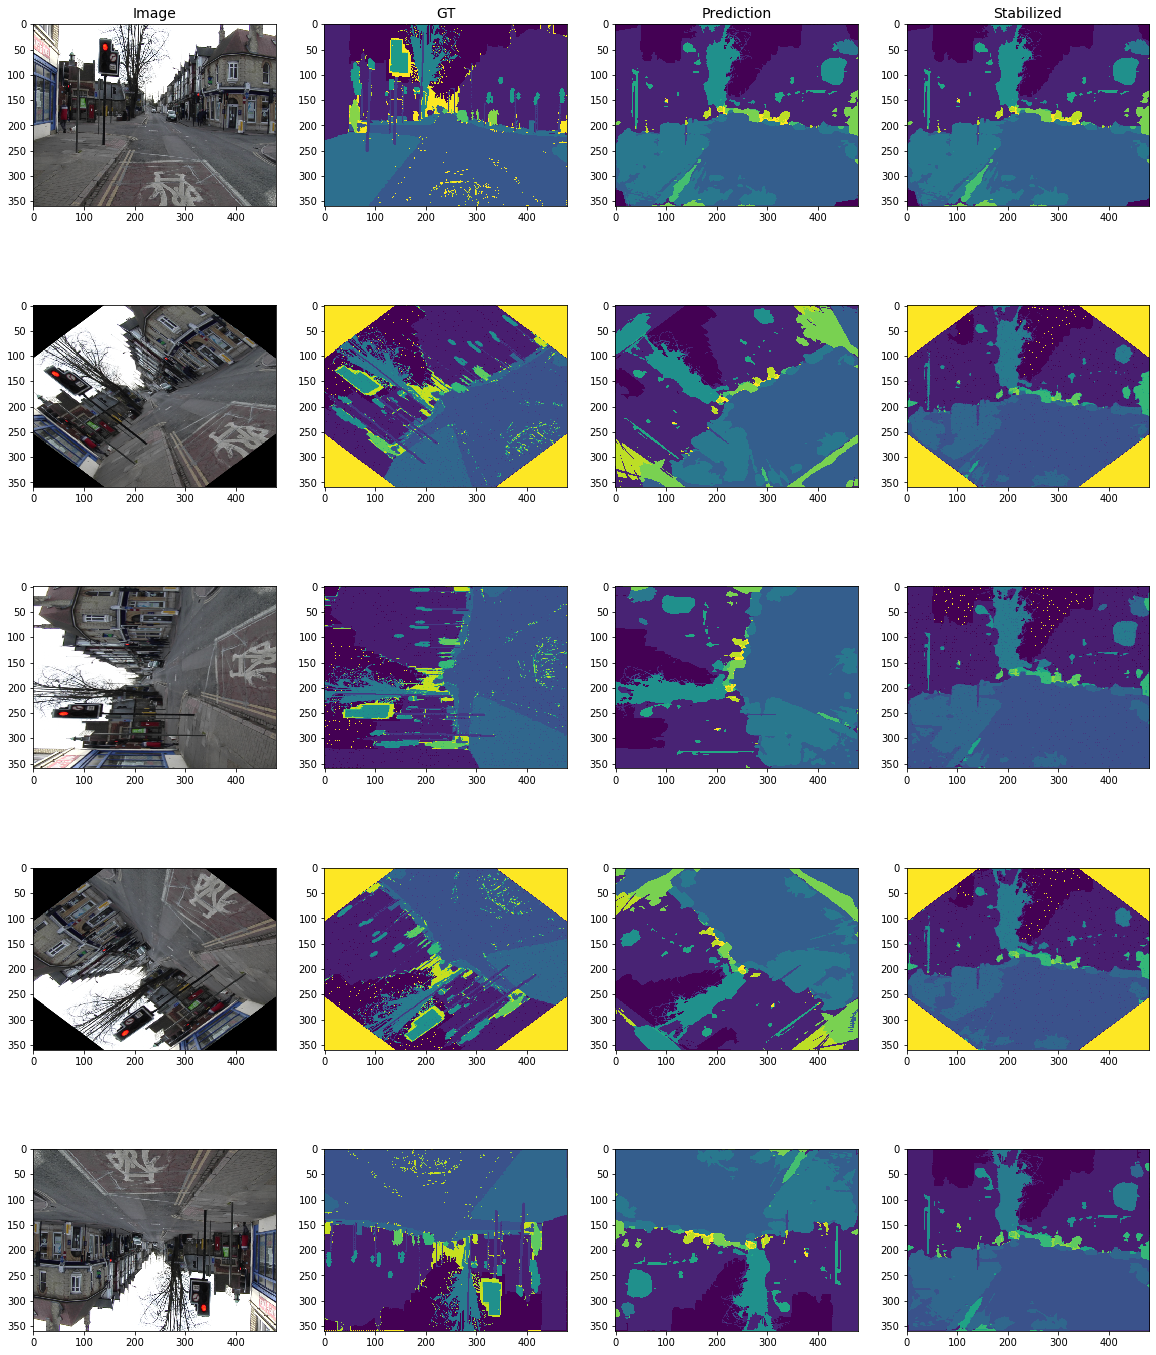

In [27]:
zs = torch.linspace(0, np.pi, 5)

nrow, ncol = len(zs), 4
f, arr = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5))

for i, z in enumerate(zs):
    x_ = rotate(x, z[None].repeat((4)))
    y_ = rotate(y, z[None].repeat((4)))
    with torch.no_grad():
        pred = augerino_model(x_.cuda())
        pred = torch.max(pred, dim=1)[1]
    pred_ = rotate(pred.detach().cpu(), -z[None].repeat((4)))
    arr[i, 0].imshow(x_[0].permute(1,2,0).detach().cpu().numpy())
    arr[i, 1].imshow(y_[0].detach().cpu().numpy())
    arr[i, 2].imshow(pred[0].detach().cpu().numpy())
    arr[i, 3].imshow(pred_[0].detach().cpu().numpy())
    
arr[0, 0].set_title("Image", fontsize=14)
arr[0, 1].set_title("GT", fontsize=14)
arr[0, 2].set_title("Prediction", fontsize=14)
arr[0, 3].set_title("Stabilized", fontsize=14)
plt.show()